In [1]:
!pip install xmltodict
!pip install split-folders
!pip install easyocr
!pip install GPUtil

import os

import numpy as np
import cv2
import uuid
import time
import pandas as pd

import xmltodict
import glob
import xml.etree.ElementTree as ET
import random as rnd
import splitfolders
import easyocr
import PIL
import copy

from pathlib import Path
from sklearn.model_selection import train_test_split
from collections import Counter
from PIL import Image
from tqdm.auto import tqdm
from GPUtil import showUtilization as gpu_usage
from numba import cuda
from timeit import default_timer as timer

import torch

import matplotlib
matplotlib.use('Agg')

from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from matplotlib import patches as mpatches

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 32.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=477be0120e48c9488e83282e538370984670787549a527bea9199c944e485719
  Stored in directory: /root/.cache/pip/wheels/92/a8/b7/d8a067c31a74de9ca252bbe53dea5f896faabd25d55f541037
Successfully built GPUtil


In [2]:
dataset = {
            "file":[],
            "width":[],
            "height":[],
            "xmin":[],
            "ymin":[],
            "xmax":[],
            "ymax":[]
           }

In [3]:
img_names=[]
annotations=[]
for dirname, _, filenames in os.walk("/content/drive/MyDrive/slnumplate"):
    for filename in filenames:
        if os.path.join(dirname, filename)[-3:]==("jpg" or "png"):
            img_names.append(filename)
        elif os.path.join(dirname, filename)[-3:]=="xml":
            annotations.append(filename)

img_names[:10]

['103.jpg',
 '111.jpg',
 '102.jpg',
 '100.jpg',
 '106.jpg',
 '107.jpg',
 '101.jpg',
 '116.jpg',
 '117.jpg',
 '11.jpg']

In [4]:
annotations[:10]

['105.xml',
 '118.xml',
 '116.xml',
 '111.xml',
 '101.xml',
 '100.xml',
 '11.xml',
 '102.xml',
 '113.xml',
 '106.xml']

In [5]:
path_annotations="/content/drive/MyDrive/slnumplate/annotations/*.xml"

for item in glob.glob(path_annotations):
    tree = ET.parse(item)

    for elem in tree.iter():
        if 'filename' in elem.tag:
            filename=elem.text
        elif 'width' in elem.tag:
            width=int(elem.text)
        elif 'height' in elem.tag:
            height=int(elem.text)
        elif 'xmin' in elem.tag:
            xmin=int(elem.text)
        elif 'ymin' in elem.tag:
            ymin=int(elem.text)
        elif 'xmax' in elem.tag:
            xmax=int(elem.text)
        elif 'ymax' in elem.tag:
            ymax=int(elem.text)

            dataset['file'].append(filename)
            dataset['width'].append(width)
            dataset['height'].append(height)
            dataset['xmin'].append(xmin)
            dataset['ymin'].append(ymin)
            dataset['xmax'].append(xmax)
            dataset['ymax'].append(ymax)

classes = ['license']

In [6]:
df=pd.DataFrame(dataset)
df

,file,width,height,xmin,ymin,xmax,ymax
0,105.jpg,350,238,131,159,244,195
1,118.jpg,734,551,400,251,478,298
2,116.jpg,734,551,248,347,363,386
3,111.jpg,850,460,269,368,322,407
4,101.jpg,480,360,133,228,198,255
...,...,...,...,...,...,...,...
260,54.jpg,800,385,333,299,446,320
261,54.jpg,800,385,639,230,709,244
262,74.jpg,800,1066,254,632,471,716
263,86.jpg,960,1280,612,874,796,1016


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   file    265 non-null    object
 1   width   265 non-null    int64 
 2   height  265 non-null    int64 
 3   xmin    265 non-null    int64 
 4   ymin    265 non-null    int64 
 5   xmax    265 non-null    int64 
 6   ymax    265 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 14.6+ KB


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.12/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['copy', 'annotations']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


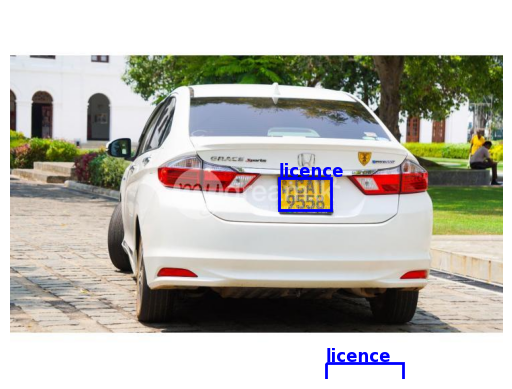

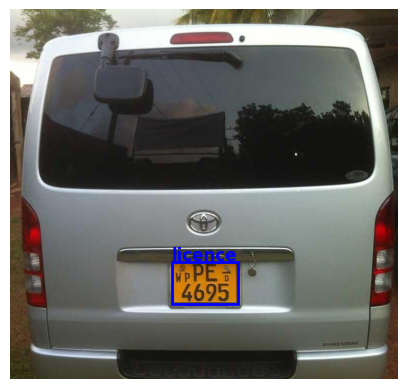

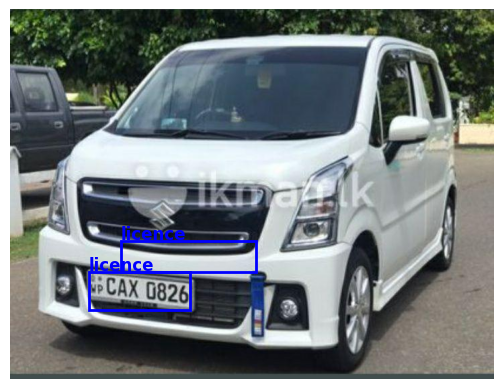

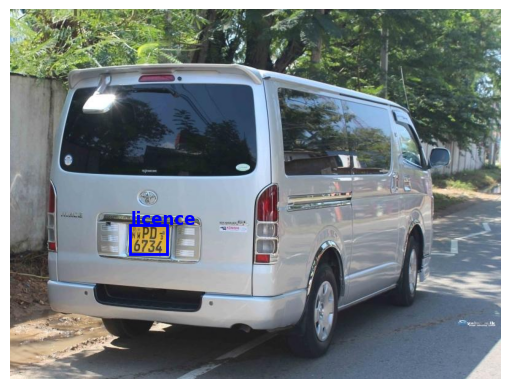

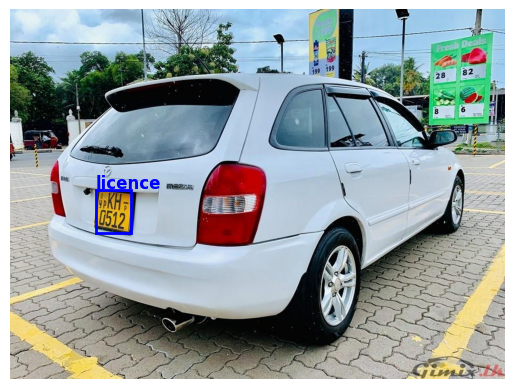

In [8]:
%pylab inline

def print_random_images(photos: list, n: int = 5, seed=None) -> None:
    if n > 10:
        n=10

    if seed:
        rnd.seed(seed)

    random_photos = rnd.sample(photos, n)

    for image_path in random_photos:

        with Image.open(image_path) as fd:
            fig, ax = plt.subplots()
            ax.imshow(fd)
            ax.axis(False)

            for i, file in enumerate(df.file):
                if file in image_path:
                    x1,y1,x2,y2=list(df.iloc[i, -4:])

                    mpatch=mpatches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1, edgecolor='b',facecolor="none",lw=2,)
                    ax.add_patch(mpatch)
                    rx, ry = mpatch.get_xy()
                    ax.annotate('licence', (rx, ry-2), color='blue', weight='bold', fontsize=12, ha='left', va='baseline')

photos_path = "/content/drive/MyDrive/slnumplate/images/*.jpg"
photos_list = glob.glob(photos_path)

print_random_images(photos_list)

In [9]:
x_pos = []
y_pos = []
frame_width = []
frame_height = []

base_path = Path("/content/drive/MyDrive/slnumplate")
labels_path = base_path / "labels"
labels_path.mkdir(parents=True, exist_ok=True)

save_type = 'w'

for i, row in enumerate(df.iloc):
    current_filename = str(row.file[:-4])

    width, height, xmin, ymin, xmax, ymax = list(df.iloc[i][-6:])

    x=(xmin+xmax)/2/width
    y=(ymin+ymax)/2/height
    width=(xmax-xmin)/width
    height=(ymax-ymin)/height

    x_pos.append(x)
    y_pos.append(y)
    frame_width.append(width)
    frame_height.append(height)

    txt = '0' + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + '\n'

    if i > 0:
        previous_filename = str(df.file[i-1][:-4])
        save_type='a+' if current_filename == previous_filename else 'w'

    with open(labels_path / (current_filename + '.txt'), save_type) as f:
        f.write(txt)


df['x_pos']=x_pos
df['y_pos']=y_pos
df['frame_width']=frame_width
df['frame_height']=frame_height

df

,file,width,height,xmin,ymin,xmax,ymax,x_pos,y_pos,frame_width,frame_height
0,105.jpg,350,238,131,159,244,195,0.535714,0.743697,0.322857,0.151261
1,118.jpg,734,551,400,251,478,298,0.598093,0.498185,0.106267,0.085299
2,116.jpg,734,551,248,347,363,386,0.416213,0.665154,0.156676,0.070780
3,111.jpg,850,460,269,368,322,407,0.347647,0.842391,0.062353,0.084783
4,101.jpg,480,360,133,228,198,255,0.344792,0.670833,0.135417,0.075000
...,...,...,...,...,...,...,...,...,...,...,...
260,54.jpg,800,385,333,299,446,320,0.486875,0.803896,0.141250,0.054545
261,54.jpg,800,385,639,230,709,244,0.842500,0.615584,0.087500,0.036364
262,74.jpg,800,1066,254,632,471,716,0.453125,0.632270,0.271250,0.078799
263,86.jpg,960,1280,612,874,796,1016,0.733333,0.738281,0.191667,0.110937


In [10]:
!git clone https://github.com/ultralytics/yolov5 /content/drive/MyDrive/slnumplate/yolov5
!pip install -r /content/drive/MyDrive/slnumplate/yolov5/requirements.txt

fatal: destination path '/content/drive/MyDrive/slnumplate/yolov5' already exists and is not an empty directory.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.3 MB/s eta 0:00:00


In [11]:
input_folder = Path("/content/drive/MyDrive/slnumplate")
output_folder = Path("/content/drive/MyDrive/slnumplate/yolov5/data/Plate_recognition")
splitfolders.ratio(
    input_folder,
    output=output_folder,
    seed=42,
    ratio=(0.8, 0.2),
    group_prefix=None
)
print("Moving files finished.")

Copying files: 764 files [04:15,  2.99 files/s]

Moving files finished.


In [12]:
def walk_through_dir(dir_path: Path) -> None:
    """Prints dir_path content"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directiories and {len(filenames)} files in '{dirpath}' folder ")


walk_through_dir(input_folder)
print()
walk_through_dir(output_folder)

There are 4 directiories and 0 files in '/content/drive/MyDrive/slnumplate' folder 
There are 0 directiories and 250 files in '/content/drive/MyDrive/slnumplate/images' folder 
There are 0 directiories and 250 files in '/content/drive/MyDrive/slnumplate/annotations' folder 
There are 0 directiories and 250 files in '/content/drive/MyDrive/slnumplate/labels' folder 
There are 7 directiories and 17 files in '/content/drive/MyDrive/slnumplate/yolov5' folder 
There are 6 directiories and 5 files in '/content/drive/MyDrive/slnumplate/yolov5/.git' folder 
There are 0 directiories and 13 files in '/content/drive/MyDrive/slnumplate/yolov5/.git/hooks' folder 
There are 0 directiories and 1 files in '/content/drive/MyDrive/slnumplate/yolov5/.git/info' folder 
There are 0 directiories and 0 files in '/content/drive/MyDrive/slnumplate/yolov5/.git/branches' folder 
There are 3 directiories and 0 files in '/content/drive/MyDrive/slnumplate/yolov5/.git/refs' folder 
There are 0 directiories and 1 fil

In [13]:
import yaml

yaml_file = '/content/drive/MyDrive/slnumplate/yolov5/data/plates.yaml'

yaml_data = dict(
    path = "data/Plate_recognition",
    train = "train",
    val = "val",
    nc = len(classes),
    names = classes
)

with open(yaml_file, 'w') as f:
    yaml.dump(yaml_data, f, explicit_start = True, default_flow_style = False)

In [15]:
from timeit import default_timer as timer

start_time = timer()

!python /content/drive/MyDrive/slnumplate/yolov5/train.py \
  --workers 2 \
  --img 800 \
  --batch 16 \
  --epochs 200 \
  --data "/content/drive/MyDrive/slnumplate/yolov5/data/plates.yaml" \
  --weights yolov5s.pt \
  --device 0 \
  --cache

end_time = timer()
print(f'Training time: {(end_time-start_time):.2f} seconds')


Streaming output truncated to the last 5000 lines.
  with torch.cuda.amp.autocast(amp):
     42/199      6.39G    0.03241   0.009191          0         37        800:   8% 1/13 [00:00<00:03,  3.10it/s]/content/drive/MyDrive/slnumplate/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
     42/199      6.39G    0.03058   0.008188          0         29        800:  15% 2/13 [00:00<00:03,  2.86it/s]/content/drive/MyDrive/slnumplate/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
     42/199      6.39G    0.02879   0.007932          0         38        800:  23% 3/13 [00:01<00:03,  2.98it/s]/content/drive/MyDrive/slnumplate/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.a

In [17]:
from google.colab import files
files.download('/content/drive/MyDrive/slnumplate/yolov5/runs/train/exp/weights/best.pt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
files.download('/content/drive/MyDrive/slnumplate/yolov5/runs/train/exp/weights/last.pt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
!pip install -r yolov5/requirements.txt


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\Keerthi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
# 1. Install PyTorch (CPU version, change to GPU version if you have CUDA)
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

# 2. Install OpenCV
!pip install opencv-python

# 3. Install easyOCR
!pip install easyocr

# 4. Install numpy (if not already installed)
!pip install numpy


Looking in indexes: https://download.pytorch.org/whl/cpu



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\Keerthi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\Keerthi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\Keerthi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\Keerthi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [21]:
import torch
import easyocr
import pathlib
import numpy as np
import cv2
import warnings

# Suppress FutureWarning messages from PyTorch
warnings.filterwarnings('ignore', category=FutureWarning)

# On Windows, unpickling objects that include pathlib.PosixPath (saved on POSIX systems)
# raises: NotImplementedError: cannot instantiate 'PosixPath' on your system.
# Map PosixPath to WindowsPath so torch.load (pickle) can instantiate paths correctly.
pathlib.PosixPath = pathlib.WindowsPath

# Windows path to your custom YOLOv5 weights
weights_path = r"C:\Users\Keerthi\Downloads\slnumplate\best.pt"

# Load custom YOLOv5 model (force_reload to avoid stale cache)
model = torch.hub.load('ultralytics/yolov5', 'custom', path=weights_path, force_reload=True)

# Initialize EasyOCR reader
reader = easyocr.Reader(['en'])

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\Keerthi/.cache\torch\hub\master.zip


YOLOv5  2025-10-26 Python-3.11.9 torch-2.7.0+cpu CPU

Fusing layers... 
Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [4]:
def get_plates_xy(frame: np.ndarray, labels: list, row: list, width: int, height: int, reader: easyocr.Reader) -> tuple:
    '''Get the results from easyOCR for each frame and return them with bounding box coordinates'''

    x1, y1, x2, y2 = int(row[0]*width), int(row[1]*height), int(row[2]*width), int(row[3]*height) ## BBOx coordniates
    plate_crop = frame[int(y1):int(y2), int(x1):int(x2)]
    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2) ## BBox
    ocr_result = reader.readtext(np.asarray(plate_crop), allowlist = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')#, paragraph="True", min_size=50)

    return ocr_result, x1, y1


def detect_text(i: int, row: list, x1: int, y1: int, ocr_result: list, detections: list, yolo_detection_prob: float=0.3) -> list:
    '''Checks the detection's probability, discards those with low prob and rewrites output from ocr_reader to >>detections<< list'''

    if row[4] >= yolo_detection_prob: #discard predictions below the value
        if(len(ocr_result))>0:
            for item in ocr_result:
                    detections[i][0]=item[1]
                    detections[i][1]=[x1, y1]
                    detections[i][2]=item[2]

    return detections


def is_adjacent(coord1: list, coord2: list) -> bool:
    '''Checks if [x, y] from list coord1 is similar to coord2'''

    MAX_PIXELS_DIFF=50

    if (abs(coord1[0] - coord2[0]) <= MAX_PIXELS_DIFF) and (abs(coord1[1] - coord2[1]) <= MAX_PIXELS_DIFF):
        return True
    else:
        return False


def sort_detections(detections: list, plates_data: list) -> list:
    '''Looks at detections from last frame and rewrites indexes for similar coordinates'''

    for m in range(0, len(detections)):
        for n in range(0, len(plates_data)):
            if not detections[m][1]==[0, 0] and not plates_data[n][1]==[0,0]:
                if is_adjacent(detections[m][1], plates_data[n][1]):
                    if m!=n:
                        temp=detections[m]
                        detections[m]=detections[n]
                        detections[n]=temp

    return detections


def delete_old_labels(detections: list, count_empty_labels: list, plates_data: list, frames_to_reset: int=3) -> tuple:
    '''If earlier detected plate isn't spotted for the next >>FRAMES_TO_RESET<< frames, delete it from >>plates_data<<'''

    for m in range(0, len(detections)):
        if detections[m][0]=='None' and not count_empty_labels[m]==frames_to_reset:
            count_empty_labels[m]+=1
        elif count_empty_labels[m]==frames_to_reset:
            count_empty_labels[m]=0
            plates_data[m]=['None', [0,0], 0]
        else:
            count_empty_labels[m]=0

    return plates_data, count_empty_labels


def overwrite_plates_data(detections: list, plates_data: list, plate_lenght=None) -> list:
    '''Checks coordinates from >>detections<<, if there is similar record in >>plate_data<< tries to overwrite it (only if probability is higher)'''

    if (detections[i][2]>plates_data[i][2] or detections[i][2]==0):
        if plate_lenght:
            if len(detections[i][0])==plate_lenght:
                plates_data[i][0]=detections[i][0]
                plates_data[i][2]=detections[i][2]
        else:
            plates_data[i][0]=detections[i][0]
            plates_data[i][2]=detections[i][2]
    plates_data[i][1]=detections[i][1]

    return plates_data

In [19]:
# Test with a single image instead of video

# Update this path to your test image
image_path = r"C:\Users\Keerthi\Downloads\slnumplate\test2.jpg"

# Read the image
frame = cv2.imread(image_path)
assert frame is not None, f"Failed to load image at {image_path}"

# Convert BGR to RGB for model inference
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Run YOLOv5 detection
results = model(frame_rgb)

# Get detection results
labels, coordinates = results.xyxyn[0][:, -1], results.xyxyn[0][:, :-1]
height, width = frame.shape[:2]

print(f"Detected {len(labels)} license plate(s)")
print(f"Image dimensions: {width}x{height}")

# Process each detected plate
for i, row in enumerate(coordinates):
    confidence = row[4]
    print(f"\nPlate {i+1} - YOLOv5 confidence: {confidence:.2f}")
    
    if confidence >= 0.3:  # Confidence threshold
        # Get bounding box coordinates
        x1, y1, x2, y2 = int(row[0]*width), int(row[1]*height), int(row[2]*width), int(row[3]*height)
        
        # Add padding to capture more context (5% on each side)
        padding_x = int((x2 - x1) * 0.05)
        padding_y = int((y2 - y1) * 0.05)
        x1 = max(0, x1 - padding_x)
        y1 = max(0, y1 - padding_y)
        x2 = min(width, x2 + padding_x)
        y2 = min(height, y2 + padding_y)
        
        print(f"Bounding box (with padding): ({x1}, {y1}) to ({x2}, {y2})")
        print(f"Crop size: {x2-x1}x{y2-y1}")
        
        # Crop the license plate region
        plate_crop = frame[y1:y2, x1:x2]
        
        # Save the original cropped plate
        crop_debug_path = r"C:\Users\Keerthi\Downloads\slnumplate\plate_crop_debug.jpg"
        cv2.imwrite(crop_debug_path, plate_crop)
        print(f"Cropped plate saved to: {crop_debug_path}")
        
        # Resize to 3x larger for better OCR accuracy
        scale_factor = 3
        h, w = plate_crop.shape[:2]
        plate_resized = cv2.resize(plate_crop, (w * scale_factor, h * scale_factor), 
                                   interpolation=cv2.INTER_CUBIC)
        
        # Save resized version
        resized_path = r"C:\Users\Keerthi\Downloads\slnumplate\plate_resized.jpg"
        cv2.imwrite(resized_path, plate_resized)
        print(f"Resized plate (3x) saved to: {resized_path}")
        
        # Draw bounding box
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
        # Run OCR on the resized plate
        print("\n--- Running OCR (Original Resized method) ---")
        ocr_result = reader.readtext(plate_resized, allowlist='0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ-')
        
        # Extract text from OCR results
        if ocr_result:
            plate_text = ' '.join([r[1] for r in ocr_result])
            ocr_confidence = max([r[2] for r in ocr_result])
            
            print(f"✅ Detected: '{plate_text}'")
            print(f"   Confidence: {ocr_confidence:.2f}")
            print(f"   Full OCR output: {ocr_result}")
            
            # Draw the text on the image
            cv2.putText(frame, plate_text, (x1, y1-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.putText(frame, f"Conf: {ocr_confidence:.2f}", (x1, y2+25), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)
        else:
            print(f"✗ Plate {i+1}: Could not read text")
            cv2.putText(frame, "UNREADABLE", (x1, y1-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

# Display the result
cv2.imshow('License Plate Detection', frame)
print("\n" + "="*60)
print("Press any key to close the window...")
print("="*60)
cv2.waitKey(0)  # Wait for any key press
cv2.destroyAllWindows()

# Save the result
output_path = r"C:\Users\Keerthi\Downloads\slnumplate\result.jpg"
cv2.imwrite(output_path, frame)
print(f"Result saved to: {output_path}")


C:\Users\Keerthi/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Detected 1 license plate(s)
Image dimensions: 168x299

Plate 1 - YOLOv5 confidence: 0.90
Bounding box (with padding): (18, 125) to (141, 157)
Crop size: 123x32
Cropped plate saved to: C:\Users\Keerthi\Downloads\slnumplate\plate_crop_debug.jpg
Resized plate (3x) saved to: C:\Users\Keerthi\Downloads\slnumplate\plate_resized.jpg

--- Running OCR (Original Resized method) ---
✅ Detected: 'CBP0999'
   Confidence: 0.95
   Full OCR output: [([[np.int32(47), 0], [np.int32(345), 0], [np.int32(345), 96], [np.int32(47), 96]], 'CBP0999', np.float64(0.9540818282661175))]

Press any key to close the window...
Result saved to: C:\Users\Keerthi\Downloads\slnumplate\result.jpg


In [ ]:
# Process video stream (webcam or video file)

# OPTION 1: Use webcam (0 = default webcam, 1 = external webcam)
video_source = r"C:\Users\Keerthi\Downloads\slnumplate\sample2.mp4"

# OPTION 2: Use video file (uncomment the line below and comment the line above)
# video_source = r"C:\Users\Keerthi\Downloads\slnumplate\test_video.mp4"

# Open video stream
cap = cv2.VideoCapture(video_source)

# Check if video opened successfully
if not cap.isOpened():
    print("Error: Could not open video stream")
else:
    print("Video stream opened successfully")
    print("Press 'q' to quit")
    
    # Optional: Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    print(f"Video: {frame_width}x{frame_height} @ {fps} FPS")
    
    # Optional: Save output video
    save_output = True  # Set to False if you don't want to save
    if save_output:
        output_video_path = r"C:\Users\Keerthi\Downloads\slnumplate\output_video.avi"
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))
        print(f"Saving output to: {output_video_path}")
    
    frame_count = 0
    
    # Process video frame by frame
    while True:
        # Read frame
        ret, frame = cap.read()
        
        # Break if no frame is captured (end of video)
        if not ret:
            print("End of video stream or failed to capture frame")
            break
        
        frame_count += 1
        
        # Convert BGR to RGB for YOLOv5
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Run YOLOv5 detection
        results = model(frame_rgb)
        
        # Get detection results
        labels, coordinates = results.xyxyn[0][:, -1], results.xyxyn[0][:, :-1]
        height, width = frame.shape[:2]
        
        # Process each detected plate
        for i, row in enumerate(coordinates):
            confidence = row[4]
            
            if confidence >= 0.3:  # Confidence threshold
                # Get bounding box coordinates
                x1, y1, x2, y2 = int(row[0]*width), int(row[1]*height), int(row[2]*width), int(row[3]*height)
                
                # Add padding
                padding_x = int((x2 - x1) * 0.05)
                padding_y = int((y2 - y1) * 0.05)
                x1 = max(0, x1 - padding_x)
                y1 = max(0, y1 - padding_y)
                x2 = min(width, x2 + padding_x)
                y2 = min(height, y2 + padding_y)
                
                # Crop and resize plate
                plate_crop = frame[y1:y2, x1:x2]
                
                if plate_crop.size > 0:  # Check if crop is valid
                    # Resize to 3x for better OCR
                    h, w = plate_crop.shape[:2]
                    plate_resized = cv2.resize(plate_crop, (w * 3, h * 3), 
                                               interpolation=cv2.INTER_CUBIC)
                    
                    # Run OCR
                    ocr_result = reader.readtext(plate_resized, 
                                                allowlist='0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ-')
                    
                    # Draw bounding box
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    
                    # Extract and display text
                    if ocr_result:
                        plate_text = ' '.join([r[1] for r in ocr_result])
                        ocr_confidence = max([r[2] for r in ocr_result])
                        
                        # Draw text on frame
                        cv2.putText(frame, plate_text, (x1, y1-10), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
                        cv2.putText(frame, f"Conf: {ocr_confidence:.2f}", (x1, y2+25), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)
                        
                        # Print to console (every 30 frames to avoid spam)
                        if frame_count % 30 == 0:
                            print(f"Frame {frame_count}: {plate_text} (conf: {ocr_confidence:.2f})")
                    else:
                        cv2.putText(frame, "DETECTING...", (x1, y1-10), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 165, 255), 2)
        
        # Display frame count
        cv2.putText(frame, f"Frame: {frame_count}", (10, 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
        # Save frame to output video
        if save_output:
            out.write(frame)
        
        # Display the frame
        cv2.imshow('License Plate Detection - Video Stream', frame)
        
        # Press 'q' to quit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            print("Quitting...")
            break
    
    # Release resources
    cap.release()
    if save_output:
        out.release()
    cv2.destroyAllWindows()
    
    print(f"\nProcessed {frame_count} frames")
    print("Video processing complete!")


Video stream opened successfully
Press 'q' to quit
Video: 1920x1080 @ 25 FPS
Saving output to: C:\Users\Keerthi\Downloads\slnumplate\output_video.avi
Frame 270: QBDB46681 (conf: 0.26)
Frame 270: QBDB46681 (conf: 0.26)


KeyboardInterrupt: 

: 